In the following, we experiment with aDM-identifiability of the true map, where $\operatorname{aDM}=0$, upon composition with a measure-preserving automorphism.

In [1]:
from jax import numpy as np
from jax import random
import jax

import numpy as onp

In [2]:
rng, flow_rng = random.split(random.PRNGKey(0))
key = rng

0. Generate and plot sources

In [3]:
# N:=Number of samples
N = 1000
# D:=Number of dimensions
D = 2

# Generate the samples
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

**!!!Don't subtract the mean here!!!** MPA only works in $[0,1]^n$.

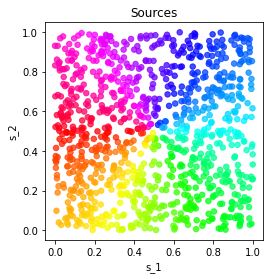

In [4]:
from plotting import cart2pol, scatterplot_variables

_, colors = cart2pol( S[:,0]-0.5, S[:,1]-0.5)
# _, colors = cart2pol( S[:,0], S[:,1])

# Plot the sources
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

1. Generate maps with $\operatorname{aDM}=0$

**Möbius transformations in $D \geq 2$**: Mixing based on Möbius transformations, see link below:

https://en.wikipedia.org/wiki/M%C3%B6bius_transformation#Higher_dimensions

In [5]:
from mixing_functions import build_moebius_transform

In [6]:
# Generate a random orthogonal matrix
from scipy.stats import ortho_group # Requires version 0.18 of scipy

A = ortho_group.rvs(dim=D)

# Scalar
alpha = 2.0
# Two vectors with data dimensionality
a = 2.0 * np.ones(D) # a vector in \RR^D
b = 3.0 * np.ones(D) # a vector in \RR^D
epsilon = 2.0

from jax import vmap
mixing_moebius, unmixing_moebius = build_moebius_transform(alpha, A, a, b, epsilon=epsilon)
mixing_batched = vmap(mixing_moebius)

In [7]:
X = mixing_batched(S)

Plot observations

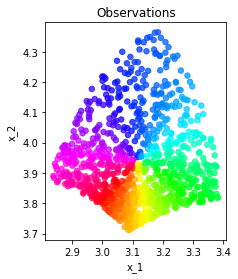

In [8]:
scatterplot_variables(X, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

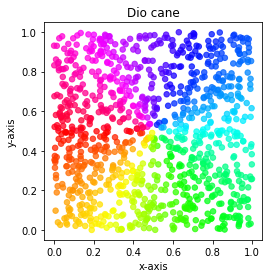

In [9]:
Z = vmap(unmixing_moebius)(X)
scatterplot_variables(Z, 'Dio cane', colors=colors, savefig=False)#True, fname="observations_flow")

2. Compose measure-preserving automorphism and Möbius transformation

In [10]:
from mixing_functions import build_automorphism

The measure preserving automorphism is indexed by a single parameter, the angle of the rotation matrix $\theta$.

In [11]:
# Build a rotation matrix

theta = np.radians(75)
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c, -s], [s, c]])

We build both the measure preserving automorphism and its inverse.

In [12]:
measure_preserving, measure_preserving_inv = build_automorphism(R)

In [13]:
measure_preserving_inv_batched = vmap(measure_preserving_inv)

We transform the sources with the direct function, and plot them.

In [14]:
Y = measure_preserving_inv_batched(S)

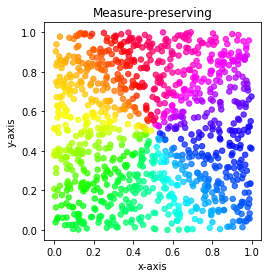

In [15]:
scatterplot_variables(Y, 'Measure-preserving', colors=colors, savefig=False)#True, fname="observations_flow")

The effect is somewhat similar to a rotation.

We now need to compose from the right the **inverse** of the mpa with the previously defined mixing. Why the inverse? Note that we have to get to the same observations,

$x$ = `mixing_moebius`($s$) 

$x$ = `composed_transformation`(`measure_preserving`($s$)) = `composed_transformation`($y$) 

In [16]:
def composed_direct_transformation(x):
    y = measure_preserving(x)
    return mixing_moebius(y)

In [17]:
composed_mixing_batched = vmap(composed_direct_transformation)

In [18]:
X_ = composed_mixing_batched(Y)
# X_ -= np.mean(X_, axis=0)

Check that we get the same observations when applying our composed mixing to Y.

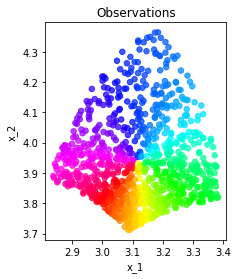

In [19]:
scatterplot_variables(X_, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

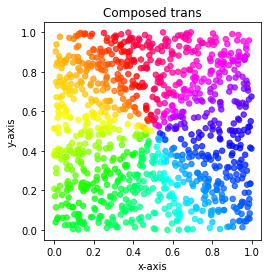

In [20]:
def composed_inverse_transformation(x):
    y = unmixing_moebius(x)
    return measure_preserving_inv(y)
comp_inv_batched = jax.vmap(composed_inverse_transformation)
Y_1 = comp_inv_batched(X_)
scatterplot_variables(Y_1, 'Composed trans', colors=colors, savefig=False)#True, fname="observations_flow")

3. Compare aDM of the true and learned solution

In [21]:
from metrics import cima

In [22]:
from jax import jacfwd

In [23]:
# # Compute the batched Jacobian
Jmixing_moebius = jacfwd(mixing_moebius)
Jmixing_moebius_batched = vmap(Jmixing_moebius)
# # Compute aDM true
true_cima = cima(X, Jmixing_moebius_batched)

In [24]:
print(np.mean(true_cima))

2.6226044e-09


In [25]:
Jcomposed = jacfwd(composed_inverse_transformation)
Jcomposed_batched = vmap(Jcomposed)
# # Compute aDM true
# composed_aDM = aDM(Jcomposed_batched, Y)
composed_aDM_cima = cima(X, Jcomposed_batched)

In [26]:
print(np.mean(composed_aDM_cima))

0.17388135


Higher!

In [27]:
from metrics import cima, cima_higher_d

In [28]:
angles = np.linspace(0, 360, num=720)
cimas = onp.copy(angles)

for i, angle in enumerate(angles):
    # Build a rotation matrix
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])

    # Build measure pres. automorphism
    measure_preserving, measure_preserving_inv = build_automorphism(R)

#     Map the sources through **direct** mpa
    measure_preserving_batched = vmap(measure_preserving)
    Y = measure_preserving_batched(S)
    
    # Compose **its inverse** it with the mixing
    def composed_inverse_transformation(x):
        y = unmixing_moebius(x)
        return measure_preserving(y)
    comp_inv_batched = jax.vmap(composed_inverse_transformation)
    Y_1 = comp_inv_batched(X)
#     print(np.argwhere(np.isnan(Y_1)).shape)
    
#     scatterplot_variables(Y_1, 'Composed trans', colors=colors, savefig=False)#True, fname="observations_flow")
    
    # Compute the Jacobian
    Jcomposed = jacfwd(composed_inverse_transformation)
    Jcomposed_batched = vmap(Jcomposed)
    # Compute aDM true
    composed_cima = np.mean(cima(X, Jcomposed_batched))
    cimas[i] = composed_cima

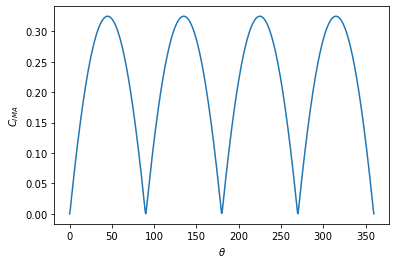

In [29]:
import matplotlib.pyplot as plt
plt.plot(angles, cimas)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')
plt.show()